In [1]:
import torch, torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_folders = sorted(glob('D:/Program Files (x86)/Softcom/Train_Spects/*'))
len(train_folders)

7

In [4]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

C:\Users\tanve\AppData\Local\Temp\ipykernel_35680\2684945866.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  images = torch.as_tensor(images)


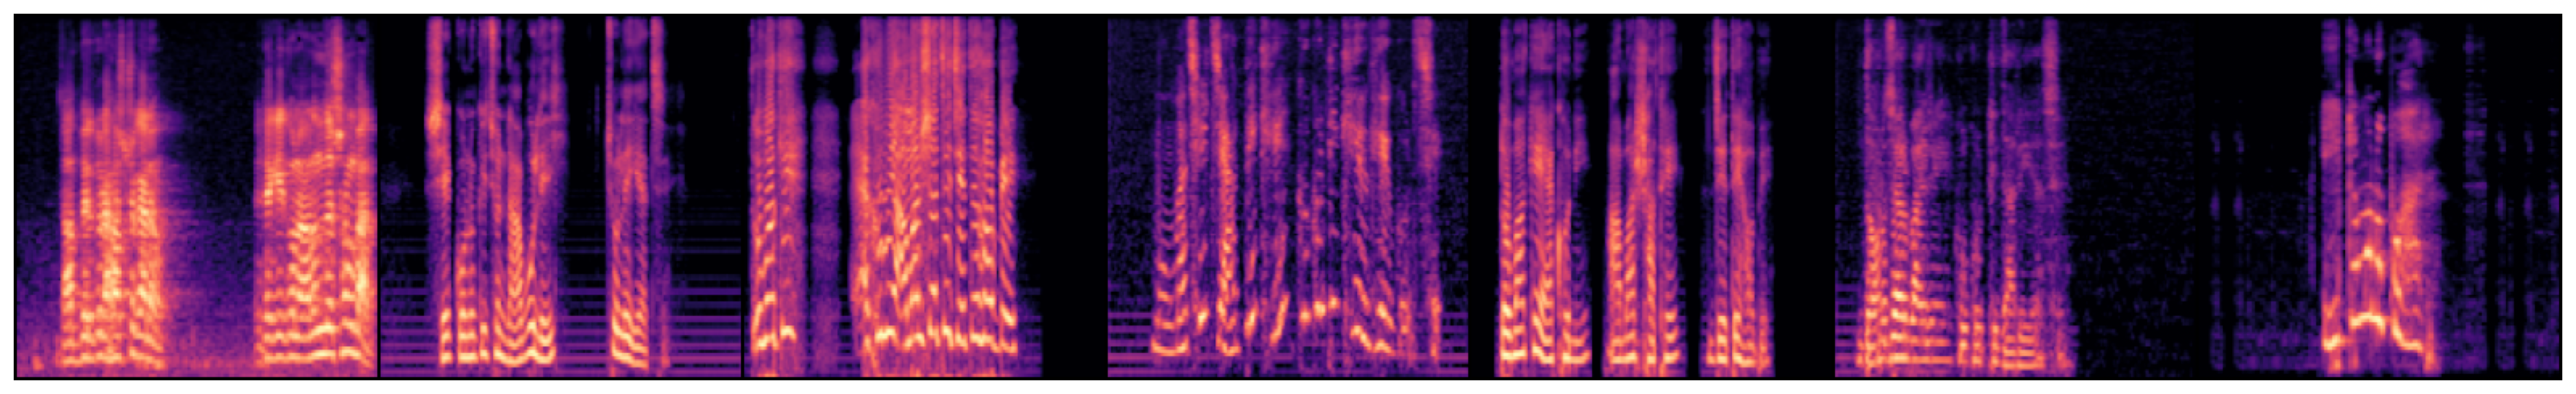

In [5]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

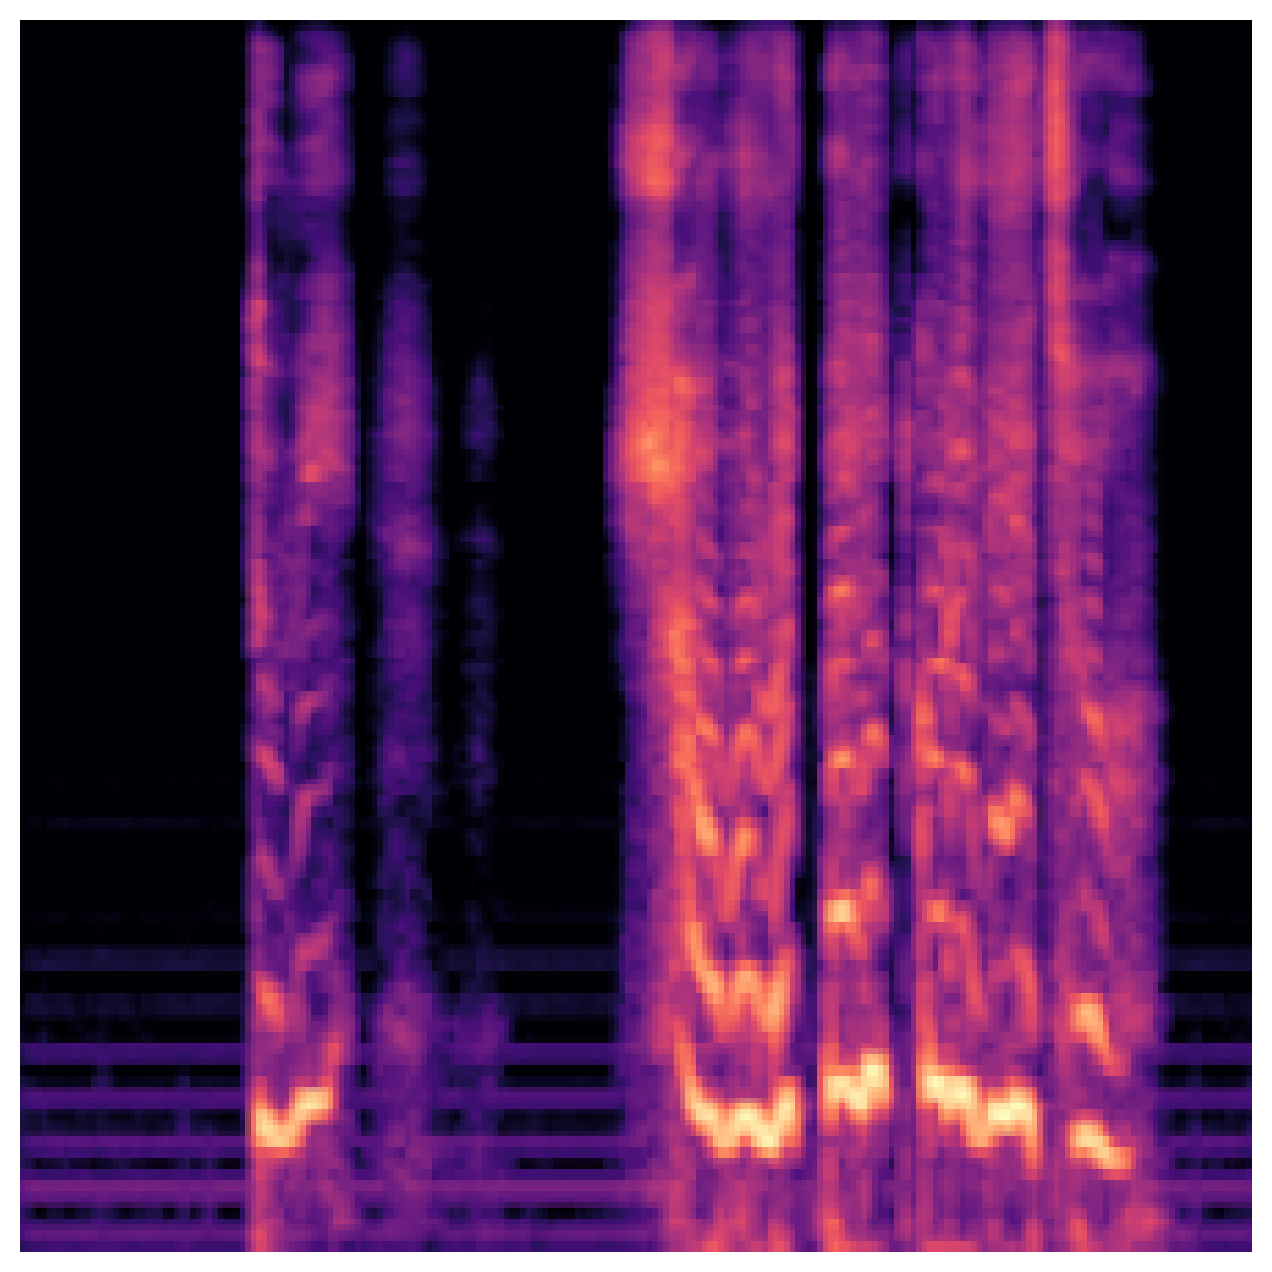

In [6]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [7]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [8]:
import subprocess
from pathlib import Path

DATA_DIR = Path('train_data')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)
    print("CLeared")

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['train', 'val']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

CLeared


In [9]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths))] #Data Split Ratio here:
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 2710
Disgust: 2160
Fear: 1800
Happy: 2710
Neutral: 2416
Sad: 2710
Surprise: 2350


In [10]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [11]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [12]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 13484, 'val': 3372}

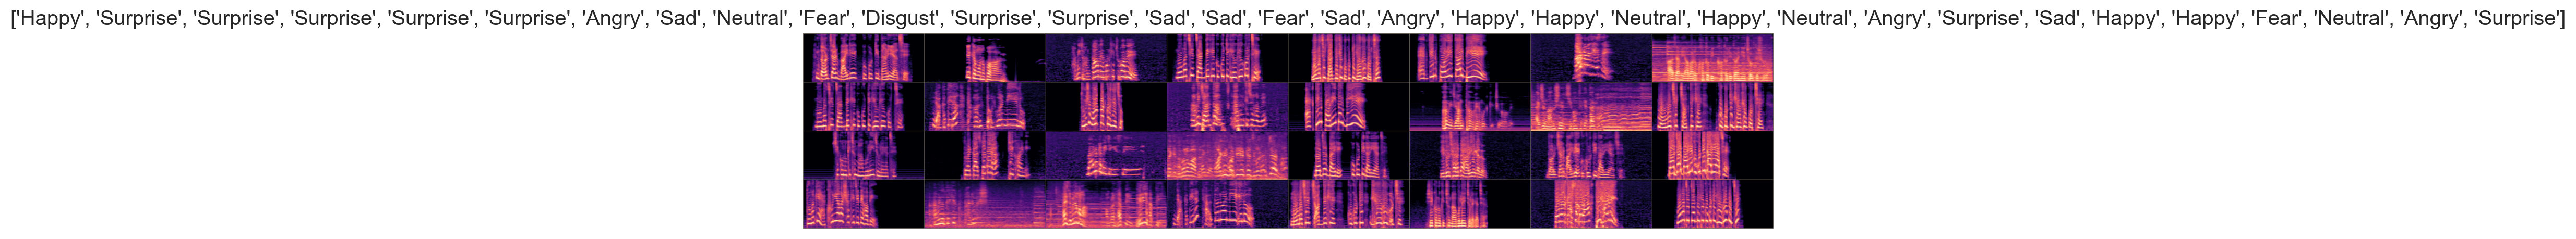

In [13]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    in_features = 512 * 7 * 7 

    model.classifier = nn.Sequential(
        nn.Flatten(),
        ResidualBlock(in_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [21]:
base_model = create_model(len(class_names))

In [22]:
IN_FEATURES = base_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, len(class_names))
base_model.classifier[-1] = final_fc
base_model = base_model.to(device)

print(base_model.classifier)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ResidualBlock(
    (fc): Linear(in_features=25088, out_features=512, bias=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (projection): Linear(in_features=25088, out_features=512, bias=True)
  )
  (2): ResidualBlock(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (projection): Linear(in_features=512, out_features=256, bias=True)
  )
  (3): ResidualBlock(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (projection): Linear(in_features=256, out_features=1

In [23]:
print(base_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [24]:
base_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
from tqdm.notebook import tqdm

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  batch_progress = tqdm(data_loader, desc='Training', leave=False)

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
    batch_progress.update(1)

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  batch_progress = tqdm(data_loader, desc='Evaluation', leave=False)
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
      batch_progress.update(1)
  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=12): #Epoch
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [28]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 1.3749235583142647 accuracy 0.45290714921388314


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.9279006275365937 accuracy 0.652135231316726

Epoch 2/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.7895625677153962 accuracy 0.7018688816374963


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.6594846127730496 accuracy 0.7514827995255042

Epoch 3/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.4983697649780043 accuracy 0.8152625333728865


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.6170882252308557 accuracy 0.7826215895610914

Epoch 4/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.3189625248171707 accuracy 0.8814891723524177


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.43058814101342885 accuracy 0.8440094899169633

Epoch 5/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.2040085751492689 accuracy 0.9265054879857609


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.48379362747073174 accuracy 0.8327402135231318

Epoch 6/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.13286404051019046 accuracy 0.9526846633046574


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.4089404333312556 accuracy 0.8704033214709372

Epoch 7/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.08961150449727137 accuracy 0.9697419163452982


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.38113555726858805 accuracy 0.8801897983392646

Epoch 8/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.022116296773752136 accuracy 0.9943636902996144


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.21162569150328636 accuracy 0.9350533807829182

Epoch 9/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.010875564755323471 accuracy 0.998294274695936


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.19752619097466176 accuracy 0.9418742586002373

Epoch 10/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.0071436579935627844 accuracy 0.9988875704538713


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.19591423603134966 accuracy 0.944246737841044

Epoch 11/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.005390272676298931 accuracy 0.9992583803025809


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.19274542951749918 accuracy 0.9445432977461448

Epoch 12/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.004231420699678035 accuracy 0.9997033521210323


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.19360820869124443 accuracy 0.9448398576512457

Best val accuracy: 0.9448398576512457
CPU times: total: 17min 25s
Wall time: 34min 22s


In [29]:
checkpoint_path = 'D:/Program Files (x86)/Softcom/vgg19_Custom3.pth'
torch.save(base_model.state_dict(), checkpoint_path)

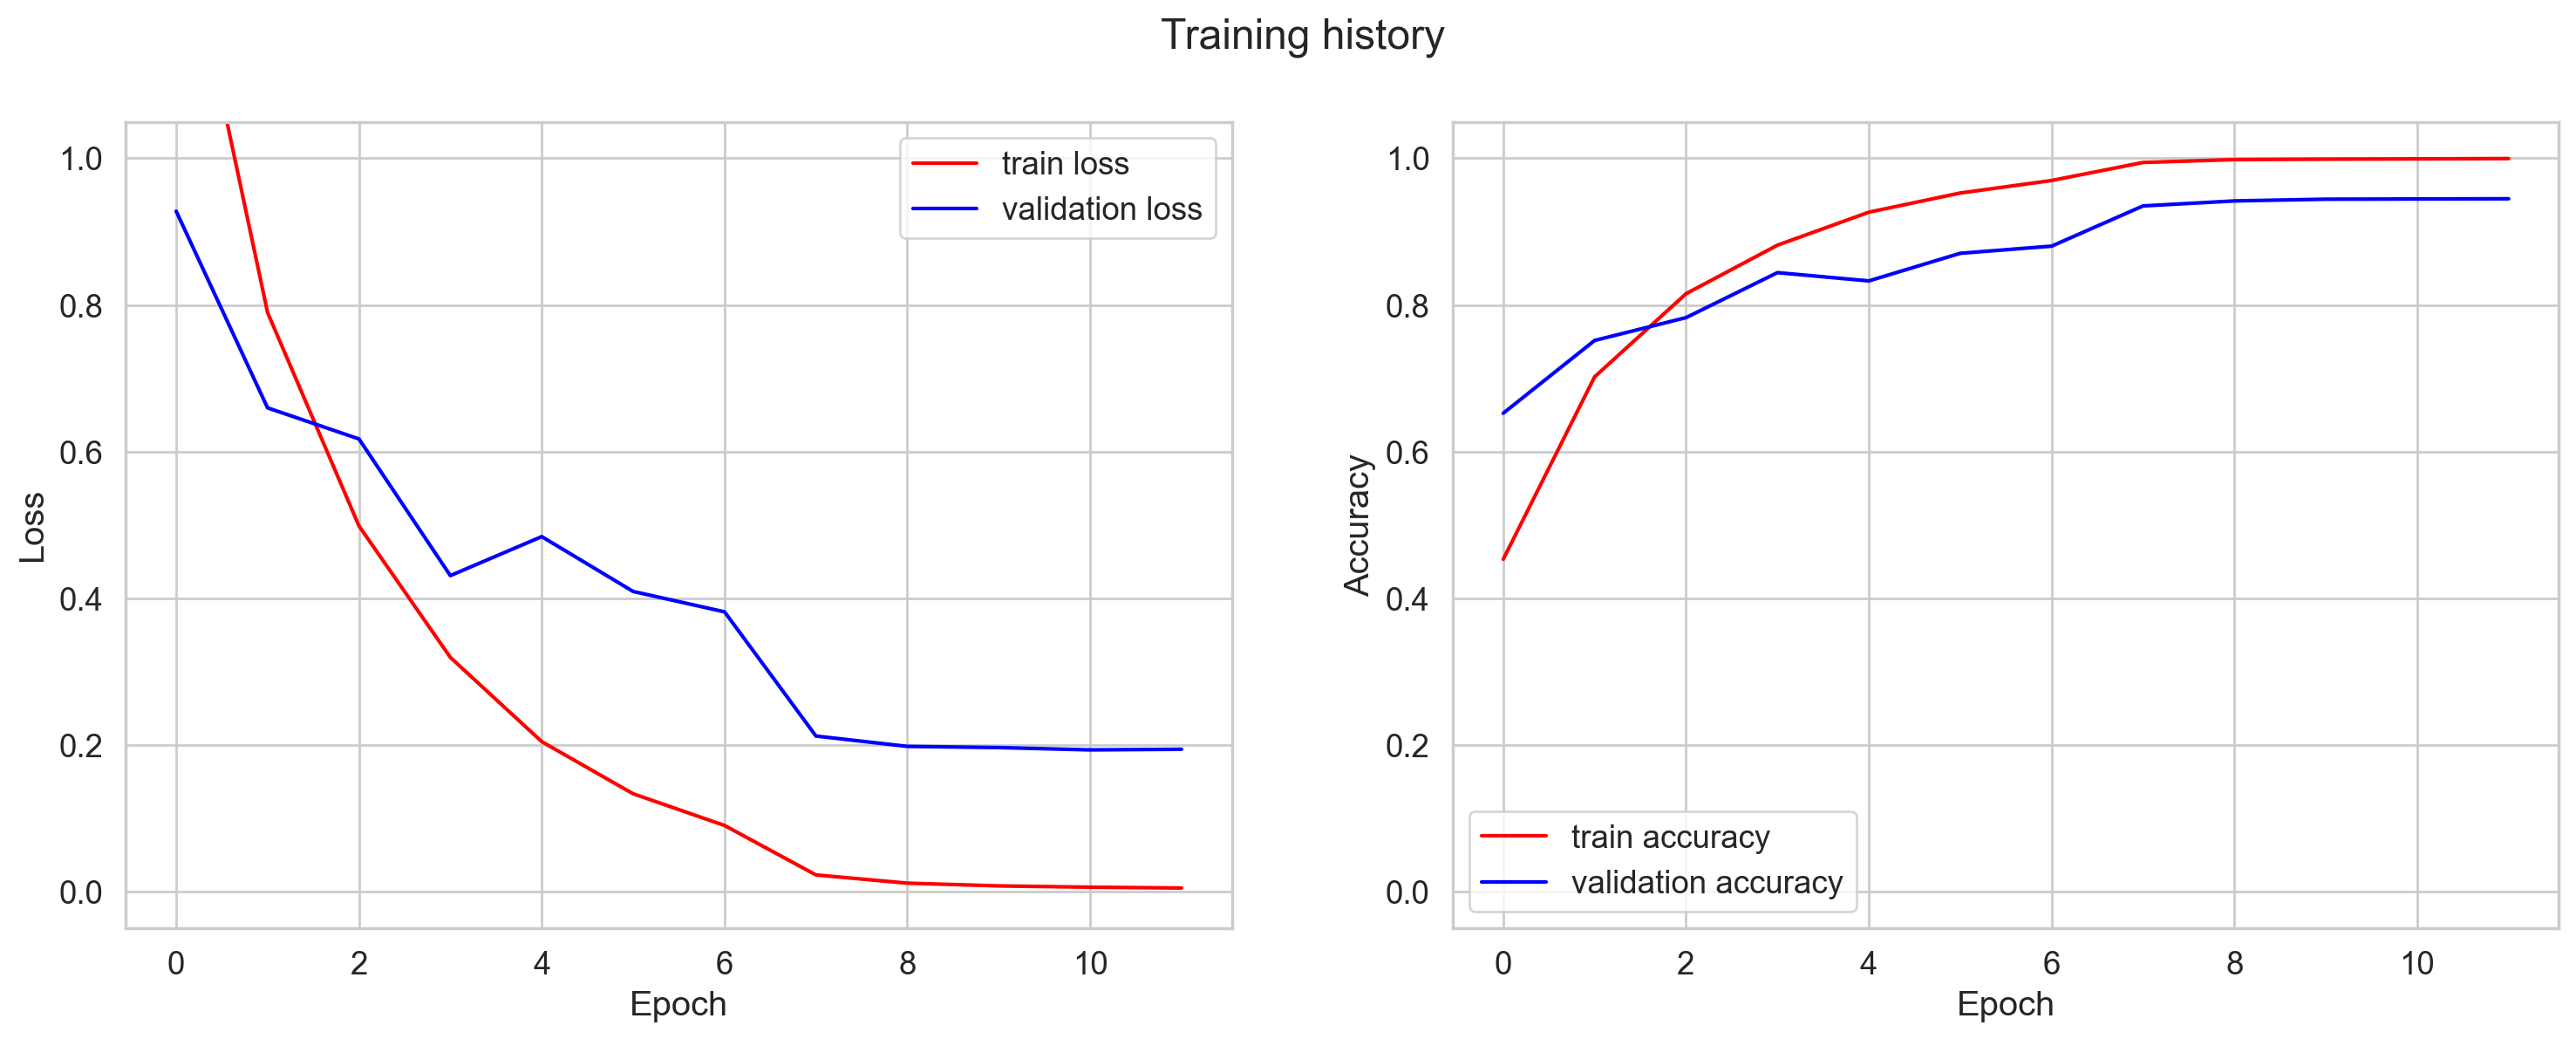

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plotting loss
    ax1.plot(history['train_loss'], label='train loss', color="red")
    ax1.plot(history['val_loss'], label='validation loss', color="blue")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    # Ensuring that tensors are on CPU and converting to NumPy arrays for plotting
    train_acc = [x.cpu().numpy() if x.is_cuda else x.numpy() for x in history['train_acc']]
    val_acc = [x.cpu().numpy() if x.is_cuda else x.numpy() for x in history['val_acc']]

    # Plotting accuracy
    ax2.plot(train_acc, label='train accuracy', color="red")
    ax2.plot(val_acc, label='validation accuracy', color="blue")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

# Assuming 'history' is a dictionary containing your training history
plot_training_history(history)


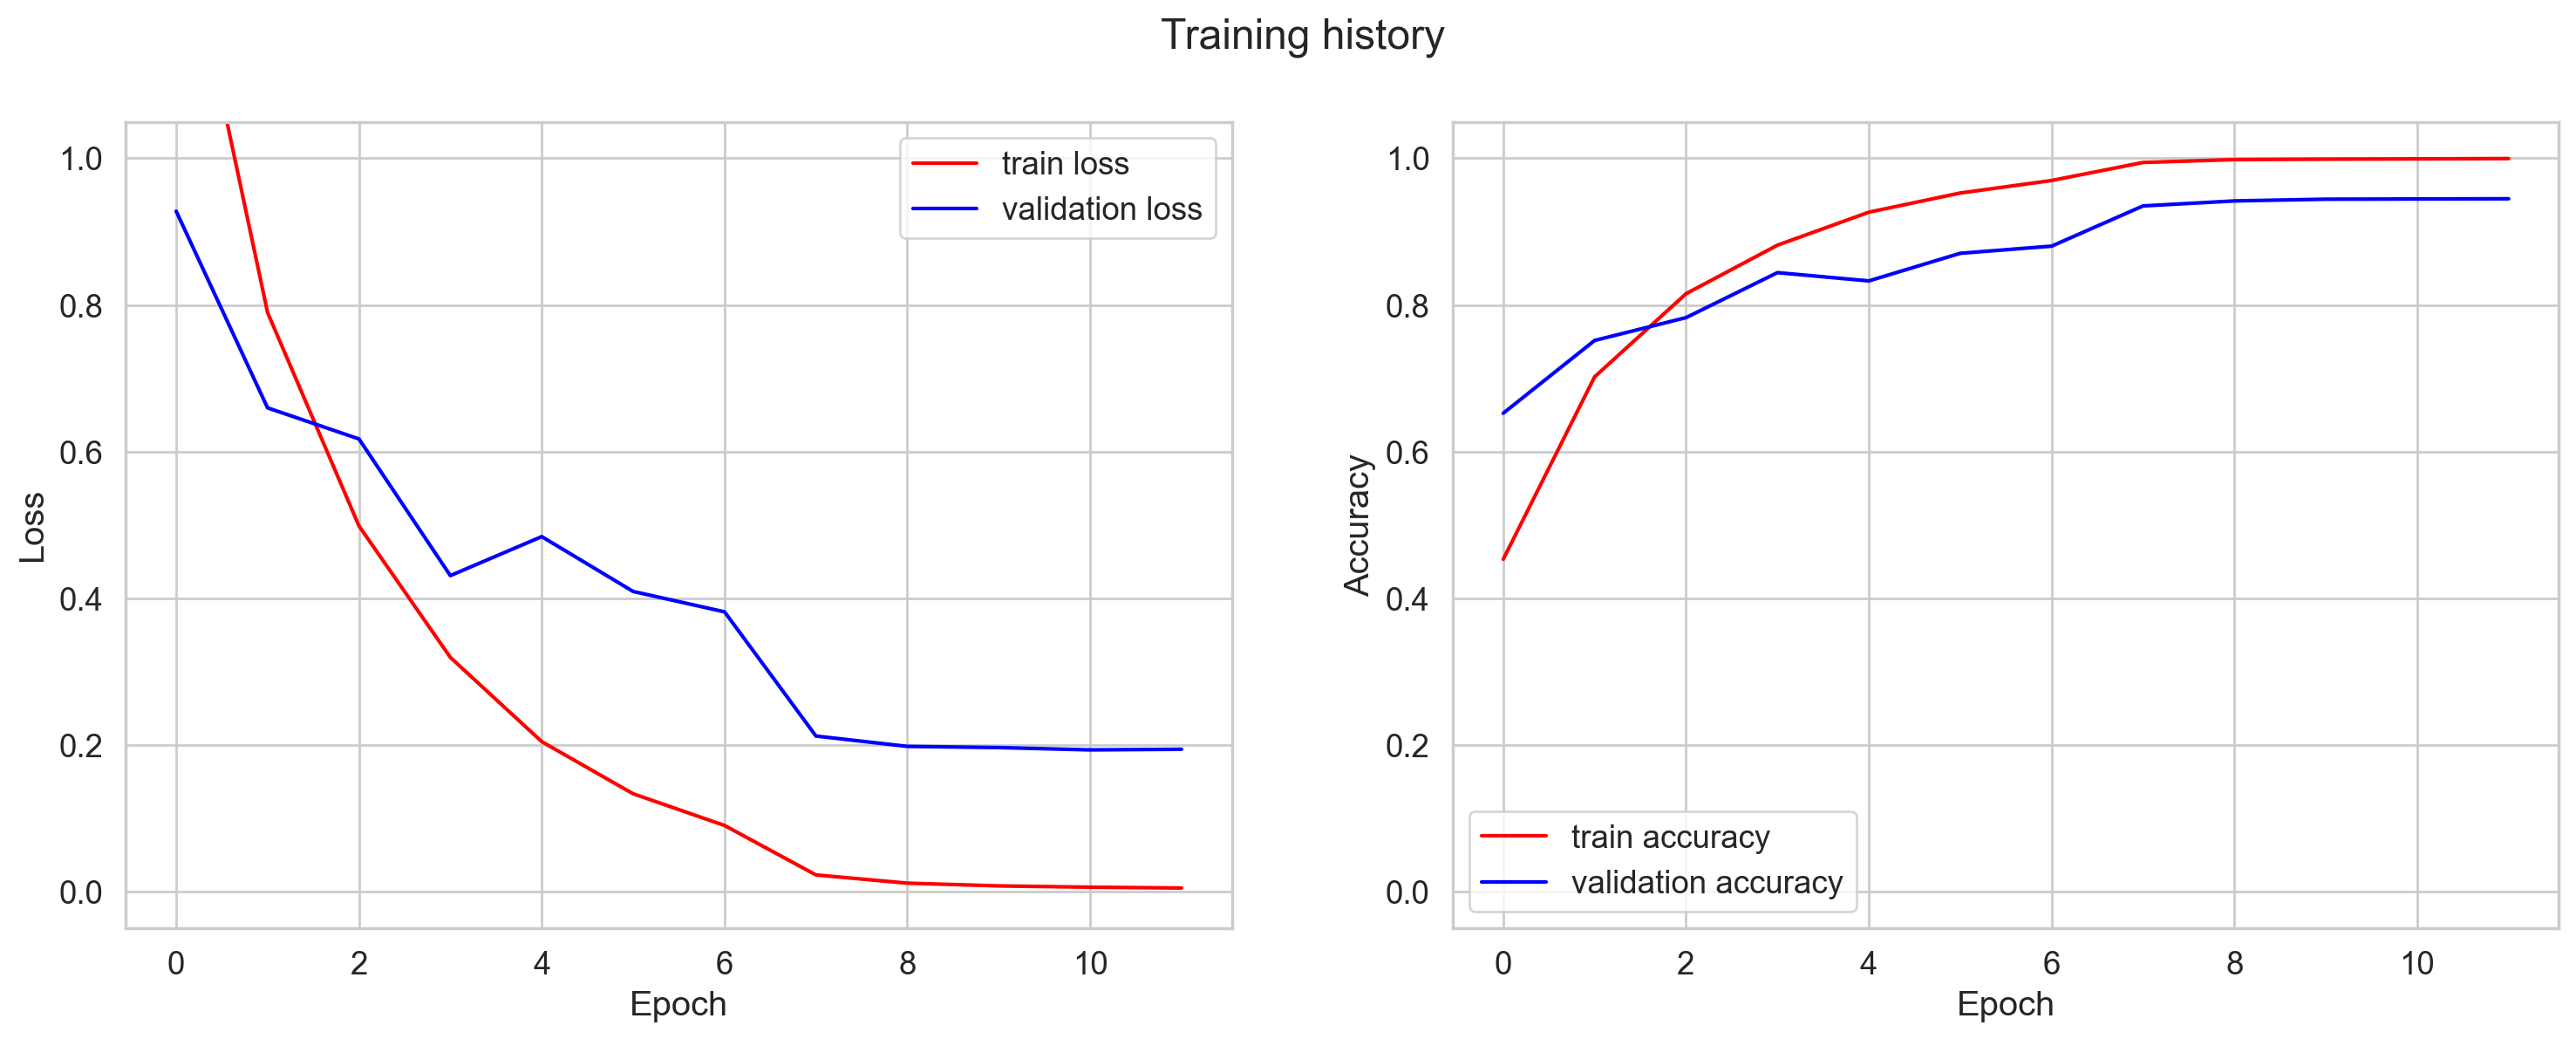

In [31]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [32]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [33]:
test_folders = sorted(glob('D:/Program Files (x86)/Softcom/Test_Spects/*'))
len(test_folders)
#E:/Thesis/Seg2_test_set_classified/0-25/* done
#E:/Thesis/Seg2_test_set_classified/25-50/* done
#E:/Thesis/Seg2_test_set_classified/50plus/* done
#E:/Thesis/Seg2_test_set/*

7

In [34]:
base_model = create_model(len(class_names))
base_model.classifier[-1]
IN_FEATURES = base_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES,len(class_names) )
base_model.classifier[-1] = final_fc
print(base_model.classifier)

checkpoint_path = 'D:/Program Files (x86)/Softcom/vgg19_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

base_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
base_model.to(device)
base_model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ResidualBlock(
    (fc): Linear(in_features=25088, out_features=512, bias=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (projection): Linear(in_features=25088, out_features=512, bias=True)
  )
  (2): ResidualBlock(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (projection): Linear(in_features=512, out_features=256, bias=True)
  )
  (3): ResidualBlock(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (projection): Linear(in_features=256, out_features=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [35]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

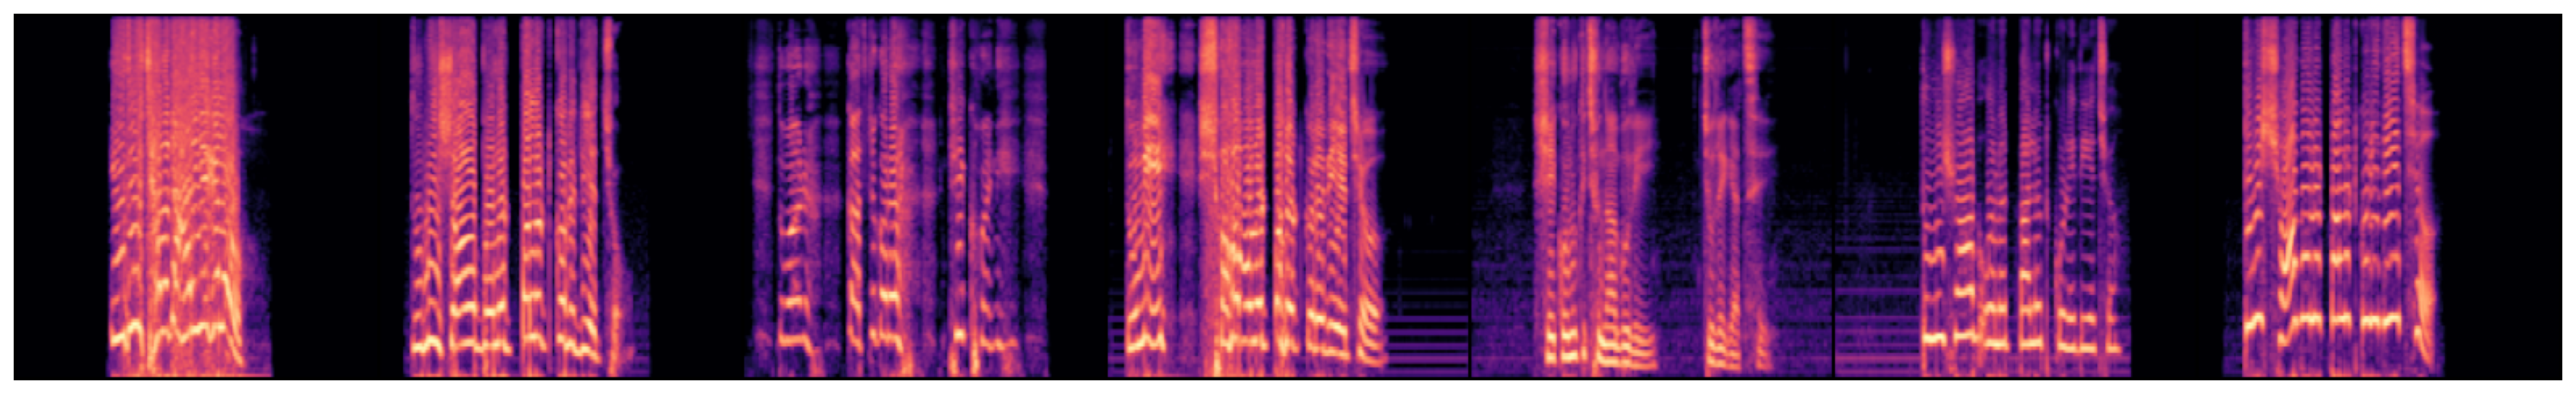

In [36]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

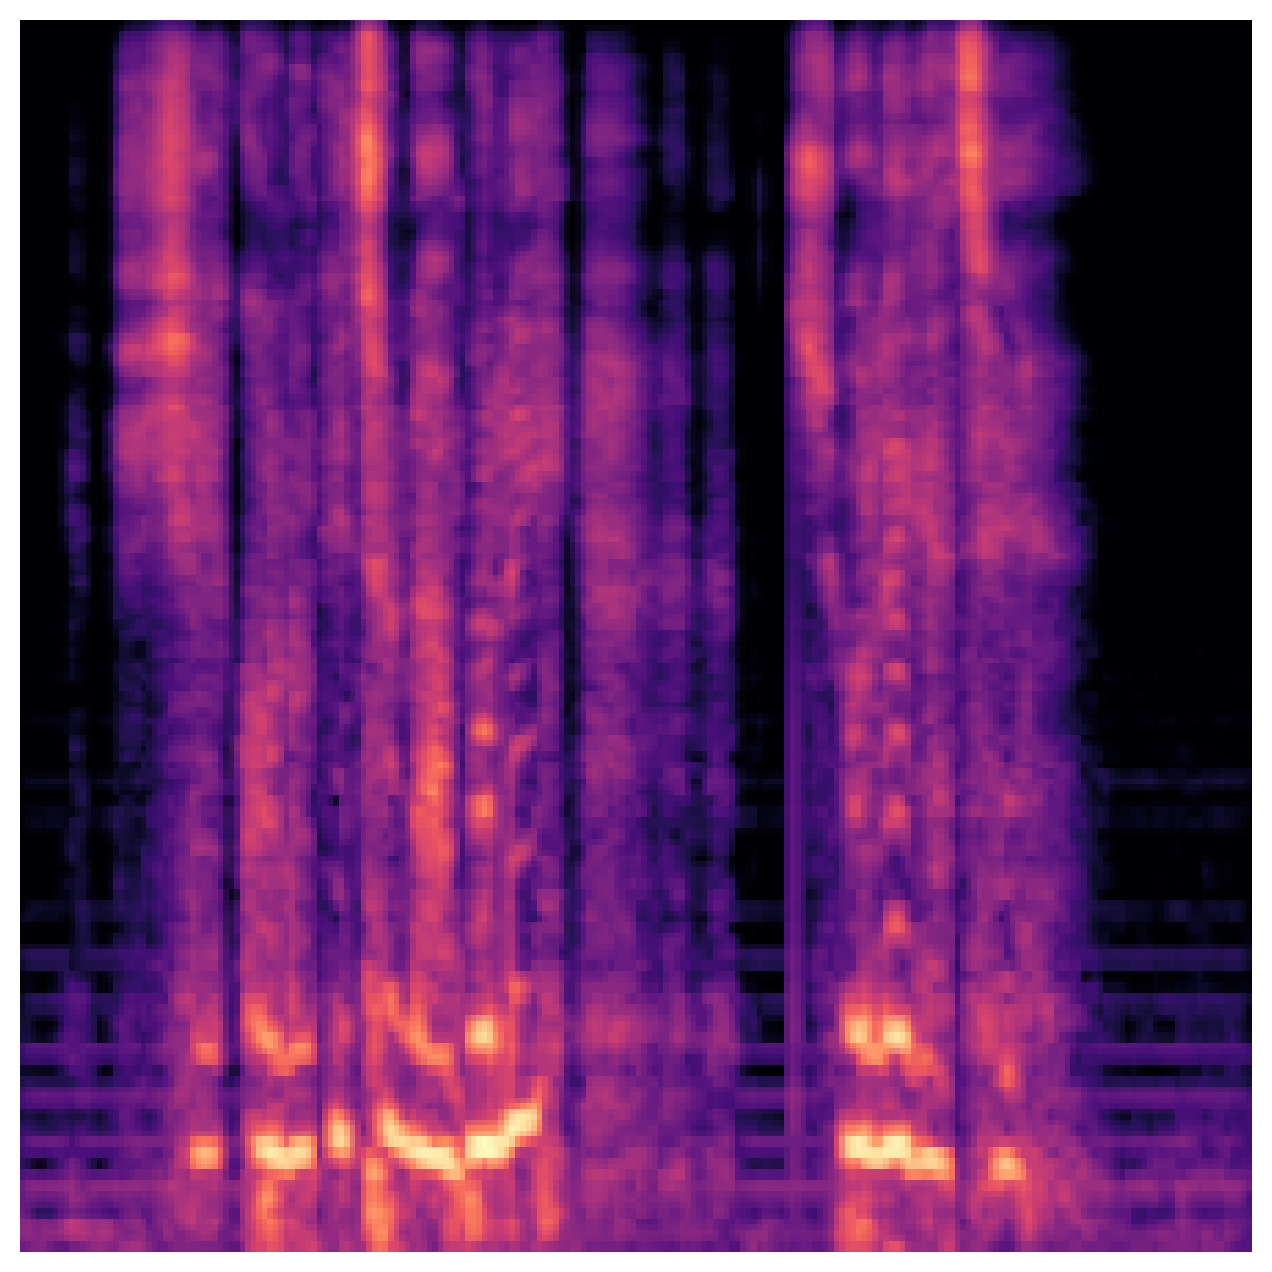

In [37]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [38]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [39]:
import subprocess
from pathlib import Path

# It's safer to check if the directory exists and then remove it using Python's built-in functions
DATA_DIR = Path('test_data')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['test']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [40]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [41]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [42]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [43]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

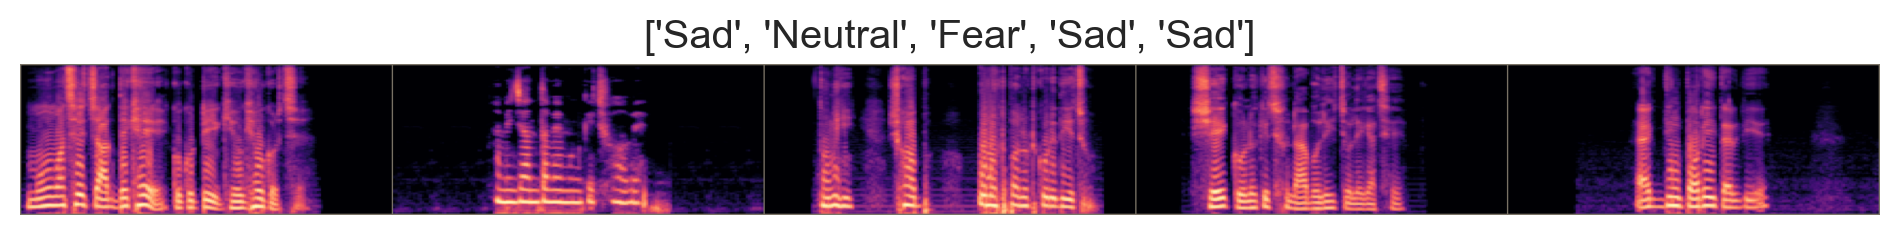

In [44]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [45]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

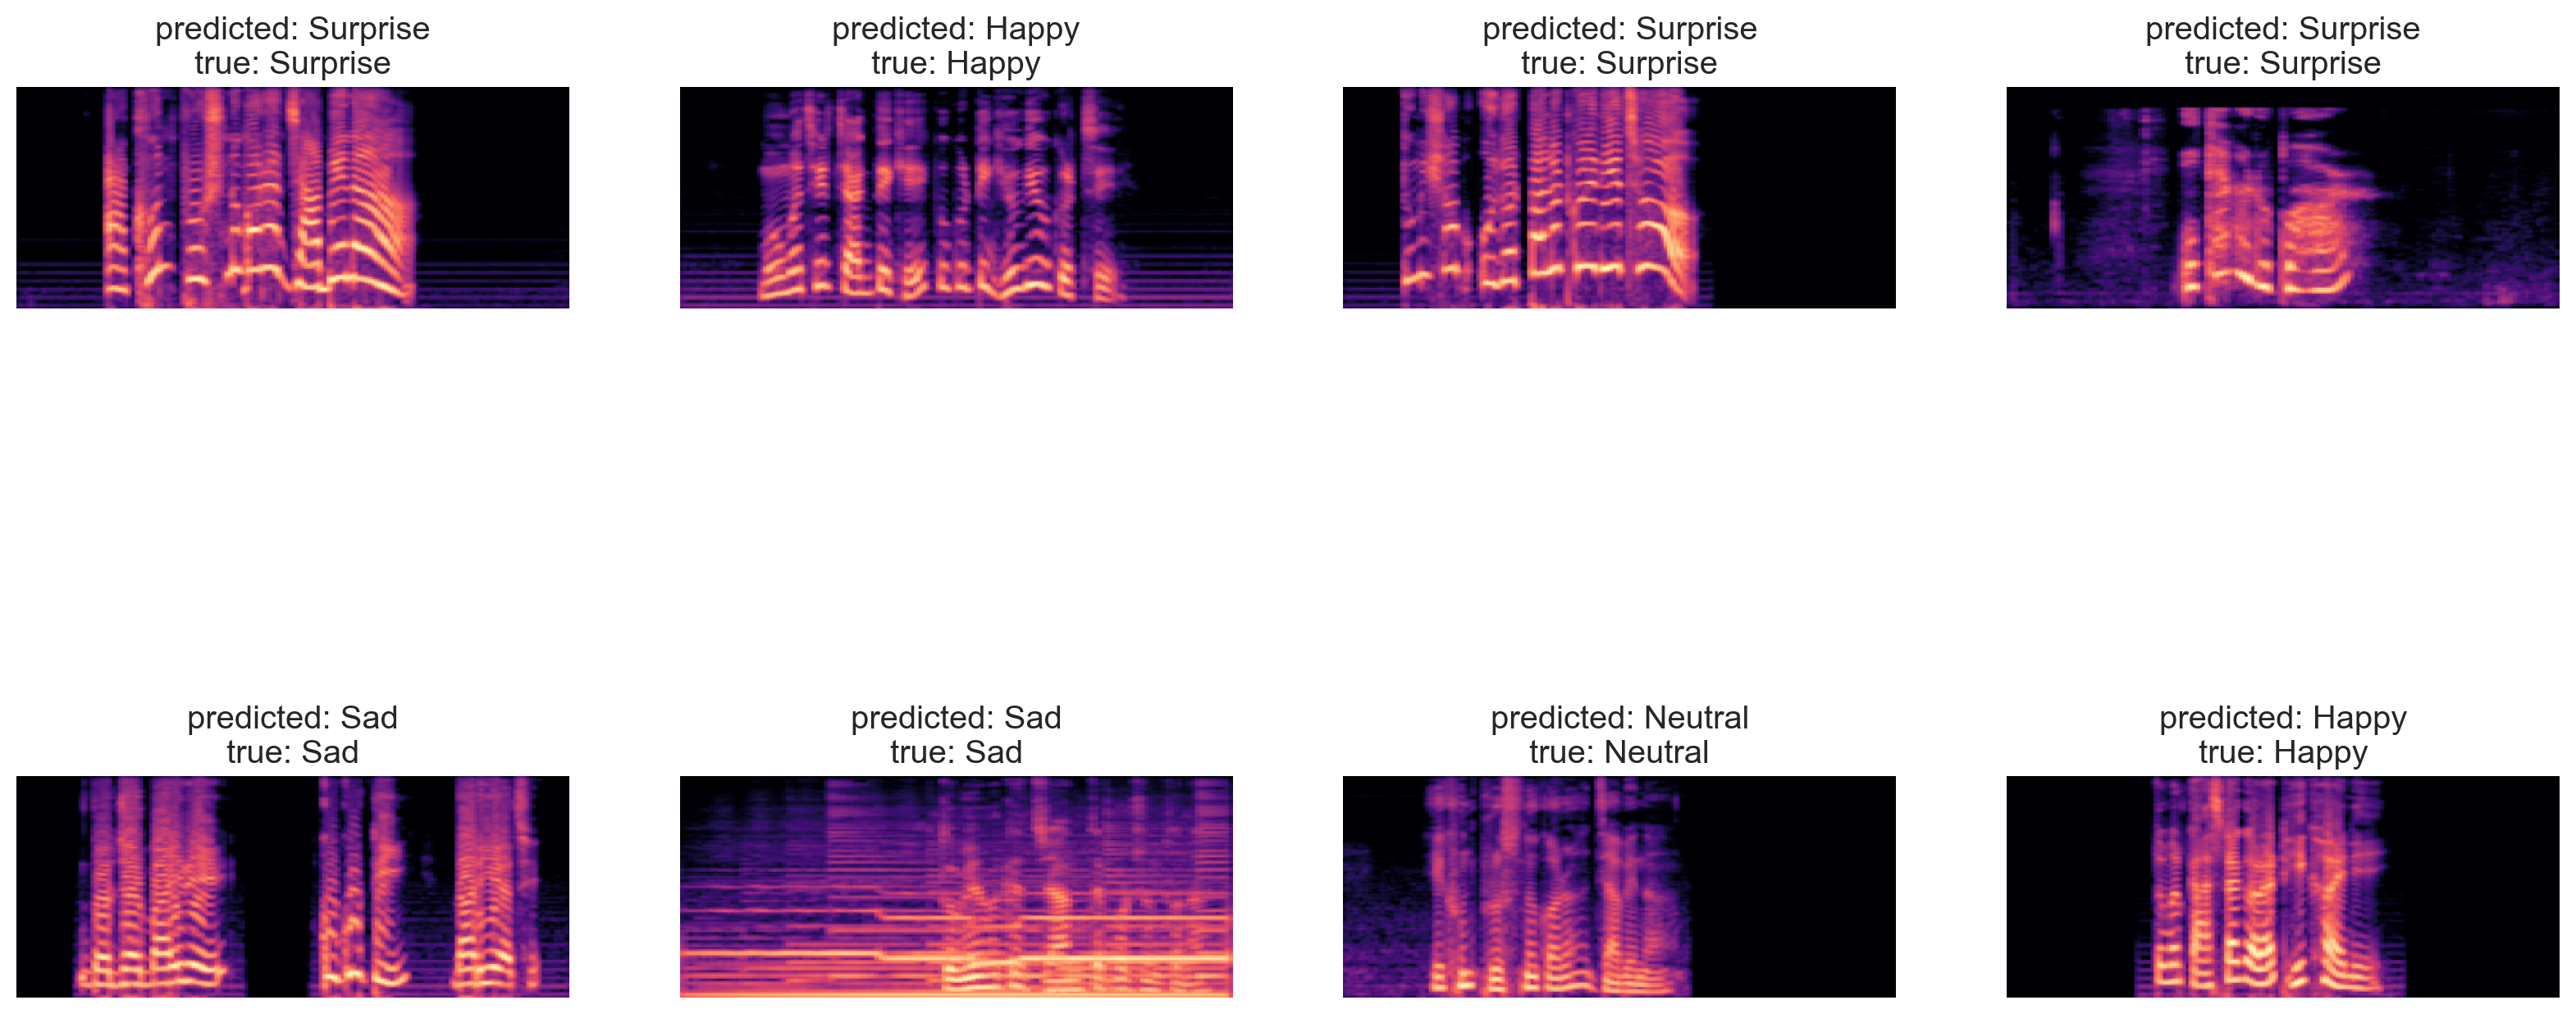

In [46]:
show_predictions(base_model, class_names, n_images=8)

In [47]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [48]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [49]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.90      0.91      0.90       151
     Disgust       0.87      0.83      0.85       120
        Fear       0.95      0.93      0.94       100
       Happy       0.90      0.88      0.89       151
     Neutral       0.90      0.96      0.93       135
         Sad       0.96      0.90      0.93       151
    Surprise       0.89      0.95      0.92       131

    accuracy                           0.91       939
   macro avg       0.91      0.91      0.91       939
weighted avg       0.91      0.91      0.91       939



In [50]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

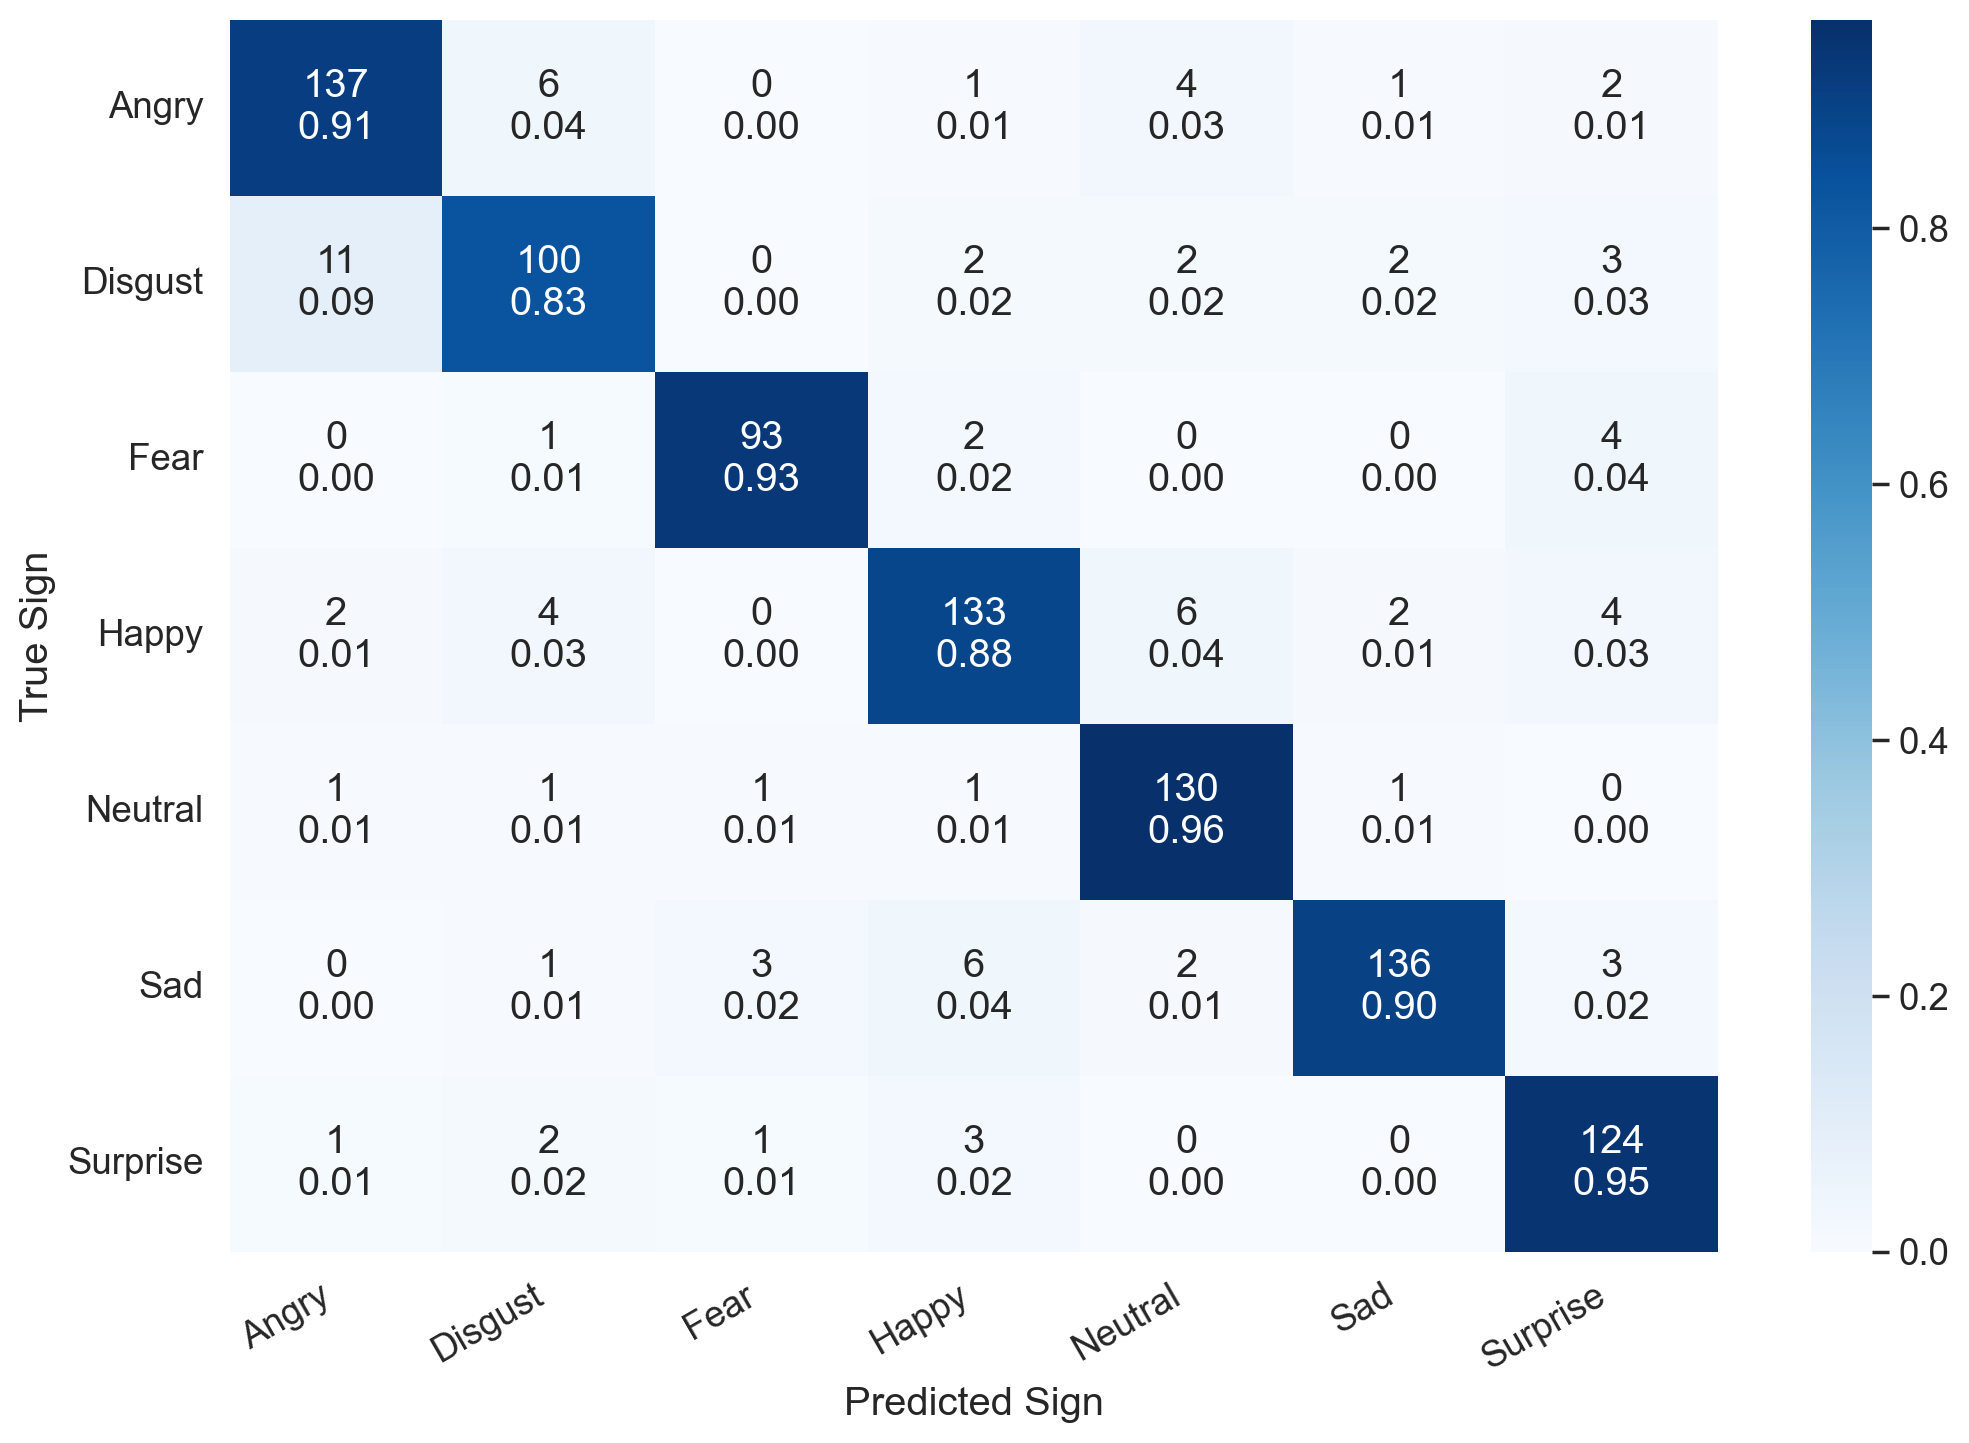

In [51]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)